In [22]:
import numpy as np
from numpy import cos, pi
import scipy.io.wavfile as sf
#from scipy.io.wavfile import read, write
import IPython
import matplotlib.pyplot as plt
from copy import copy

In [23]:
def levinson(seg: list, samples_ammount: int, ar_rank: int):
    """Levinson-Durbin algorithm

    Args:
        seg (list): Data Segment
        samples_ammount (int): Number of samples in segment
        ar_rank (int): AR rank

    Returns:
        k (list): Reflection coeeficients
    """
    # Calculate autocorrelation coefficients
    p = np.zeros(ar_rank+1)
    for i in range(ar_rank+1):
        for t in range(i, samples_ammount):
            p[i] = p[i] + seg[t] * seg[t-i]
    
    # Solving Yole-Walker equations
    a = np.zeros((ar_rank, ar_rank))
    sigma = np.zeros(11)
    k = np.zeros(10)
    sigma[0] = p[0]
    k[0] = p[1]/p[0]
    a[0,0] = k[0]
    sigma[1] = (1-k[0]**2)*sigma[0]
    for i in range(1, ar_rank):
        x = 0
        for j in range(0, i):
            x = x + a[j,i-1]*p[i-j]
        k[i] = (p[i+1]-x)/sigma[i]
        a[i,i] = k[i]
        for j in range(0, i):
            a[j,i] = a[j, i-1] - k[i]*a[i-j-1, i-1]
        sigma[i+1] = (1-k[i]**2) * sigma[i]
    
    return k

In [24]:
def play_sound(sound, rate=11025):
    return  IPython.display.display(IPython.display.Audio(sound, rate=rate))
# Read wave file
track = sf.read("data/01.wav")
input_arr = np.array(track[1], dtype=float)
print(type(input_arr))
input_arr = np.concatenate((input_arr, np.zeros(13)))
# play_sound(track[1])

<class 'numpy.ndarray'>


/tmp/ipykernel_43635/1545670050.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  track = sf.read("data/01.wav")


In [25]:
track[1].shape

(229619,)

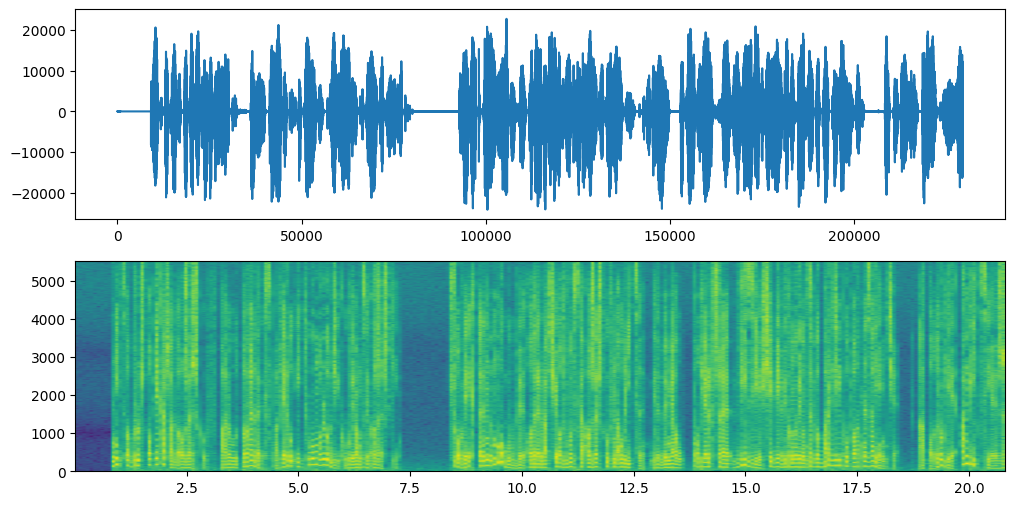

In [26]:
# Ploting track with specgram
plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
plt.plot(track[1])

plt.subplot(2, 1, 2)
plt.specgram(track[1], NFFT=1024, Fs=track[0])

plt.show()

In [27]:
# Weight for flattening edges
def weight(k: np.ndarray):
    weight = 0.5*(1-cos(2*pi*k/ (257)))
    weight = np.roll(weight, -1)
    return weight

# Prepare variable for storing flattened segments
# flattened_segments = copy(segments)

# Flattening samples in each segment
# for i in range(0, len(flattened_segments)):
#     for n in range(1, len(flattened_segments[i])):
#         flattened_segments[i][n] *= weight(n)
# flattened_segments = np.array(flattened_segments)

In [28]:
samples_ammount=256
ar_rank=10

In [29]:

t = np.arange(samples_ammount)
segment_id = 0

e_g = np.zeros((len(input_arr) // samples_ammount) * samples_ammount + 1)
e_max_g = np.zeros(len(input_arr) // samples_ammount)
a_g = np.zeros((len(input_arr) // samples_ammount + 1) * ar_rank)

while t[-1] < len(input_arr):
        segment_id += 1
        y = input_arr[t]
        yw = y * weight(np.arange(samples_ammount))
        yr = np.concatenate((np.zeros(ar_rank), yw, np.zeros(ar_rank)))

        e = np.zeros(samples_ammount)

        track = np.zeros(ar_rank)
        r2 =  np.correlate(y, y, mode='full')
        lg = np.arange(-255, 256)
        r2 = r2[lg >= 0]
        # a = ld(r2, 10)[1:]

        ld_result = levinson(yr, samples_ammount, ar_rank)
        
        if segment_id == 1:
            y = np.concatenate((np.zeros(ar_rank), y))
        else:
            y = np.concatenate((input_arr[t[0]-ar_rank:t[0]], y))

        for i in range(samples_ammount):
            e[i] = y[i+ar_rank] + np.sum(y[i:i+ar_rank][::-1] * track)
        e_g[t] = e

        e_max = max(abs(e))
        e_max_g[segment_id-1] = e_max
        a_g[(segment_id-1)*ar_rank:segment_id*ar_rank] = track

        t = t + samples_ammount

In [35]:
def odb(a, e_max, e):
    samples_ammount = 256
    ar_rank = 10
    segment_n = len(e_max)
    y_o = np.zeros(ar_rank + segment_n*samples_ammount + 1)

    for i in range(segment_n):
        p_s = ar_rank + i * samples_ammount
        y_s = np.zeros(samples_ammount)
        a_s = a[i*ar_rank:(i+1)*ar_rank]
        for j in range(samples_ammount):
            p_s2 = p_s + j
            y_s[j] = -np.sum(y_o[p_s2-ar_rank:p_s2][::-1] * a_s) + e[i * samples_ammount + j]
        y_o[p_s:p_s+samples_ammount] = y_s

    sf.write('wiersz_reconstructed_1b.wav', rate=11025, data=y_o)

    return y_o

In [36]:
odb(a_g, e_max_g, e_g)

array([0., 0., 0., ..., 0., 0., 0.])